# Calibration scores

Confidence is estimated using MC dropout, by taking mean softmax output of all n dropout runs.

Calibration plots show the fraction of true positives within all predictions in a certain confidence bin. The histogram shows the amount of predictions in confidence bins. These plots are generated for both per-vertex and per-cluster values. Per-cluster confidences are the mean of confidence values within one cluster.

The expected calibration error is the absolute differences of per-bin frequencies and confidences, weighted by the number of predictions in each bin. Lower is better, 0 is best. 

These scores are inspired from https://arxiv.org/pdf/1911.13273.pdf


NOTES:
- with new sigmoid parameters confidence without dropout is well calibrated
- could tune dropout parameter on trainval & confirm on test (?)
- per-cluster confidences that look only at confidences high-saliency vertices are even better calibrated

In [1]:
from meld_graph.evaluation import load_prediction, Evaluator
from meld_graph.experiment import Experiment
from meld_graph.dataset import GraphDataset
import meld_graph.confidence
import h5py
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Setting MELD_DATA_PATH to /rds/user/kw350/rds-kw350-meld/meld_data/Data/
Setting BASE_PATH to /rds/user/kw350/rds-kw350-meld/meld_data/Data/
Setting EXPERIMENT_PATH to /rds/user/kw350/rds-kw350-meld/experiments/kw350/
No fs_subjects_path defined in /home/kw350/software/gdl/meld_classifier/meld_config.ini!
No meld_params_path defined in /home/kw350/software/gdl/meld_classifier/meld_config.ini!
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350


## evaluate model with MC dropout

run 
```
python calculate_dropout_confidence.py --model_path '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/23-08-30_IGKW_object_save_final/s_0/fold_all' --split test --model_name ensemble_best_model.pt --p 0.8 --n 10
```

## Load data for calibration plots

In [2]:
# model paths
model_path = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all'
model_name = 'best_model'
split = 'test'

# set suffix for correct loading & saving of files
suffix = ""
if split == "trainval":
    suffix = "_trainval"

# load experiment
exp = Experiment.from_folder(model_path)
features = exp.data_parameters['features']
cohort = exp.cohort

# load evaluator with small dataset (don't need this dataset, but want to keep loading time down)
train_ids, val_ids, test_ids = exp.get_train_val_test_ids()
dataset = GraphDataset(test_ids[:1], exp.cohort, exp.data_parameters, mode="test")
eva = Evaluator(exp, dataset=dataset, model_name=model_name, thresh_and_clust=True)  
# thresh_and_clust flag needed such that loads sigmoid parameters from file

# get subjects
if split == 'trainval':
    subjects = exp.data_parameters['train_ids'] + exp.data_parameters['val_ids']
else:
    subjects = exp.data_parameters[f'{split}_ids']
print(len(subjects))

Initialised Experiment 23-10-30_LVHZ_dcp/s_0


/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all


Loading and preprocessing test data


MELD_H2_15T_FCD_0001


Z-scoring data for MELD_H2_15T_FCD_0001


FileNotFoundError: fsaverage_sym/label/lh.cortex.label not found.

In [ ]:
# check how many subject are in prediction file that we want to use below
prediction_fname = os.path.join(model_path, f'results_{model_name}/predictions.hdf5')


453


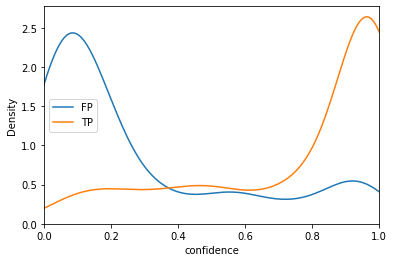

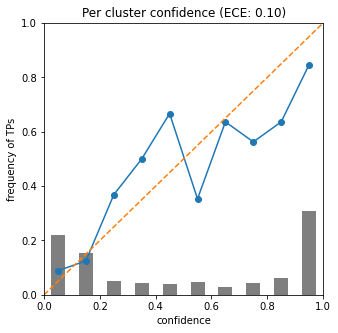

In [ ]:
prediction_suffix = confidence_suffix = suffix

# per vertex confidence
results_dict = meld_graph.confidence.get_confidence(eva, subjects, cohort, prediction_suffix=prediction_suffix, confidence_suffix=confidence_suffix)

#results_df_saliency = meld_graph.confidence.calculate_per_cluster_confidence(results_dict, aggregation_fn='max', mask_by_saliency=True, eva=eva, prediction_suffix=prediction_suffix)
#per_cluster_confidence, per_cluster_label = np.array(results_df_saliency['confidence']), np.array(results_df_saliency['TP'])

#fig2 = meld_graph.confidence.confidence_label_distplot(per_cluster_confidence, per_cluster_label)
#fig3 = meld_graph.confidence.cluster_calibration_plot(per_cluster_confidence, per_cluster_label)

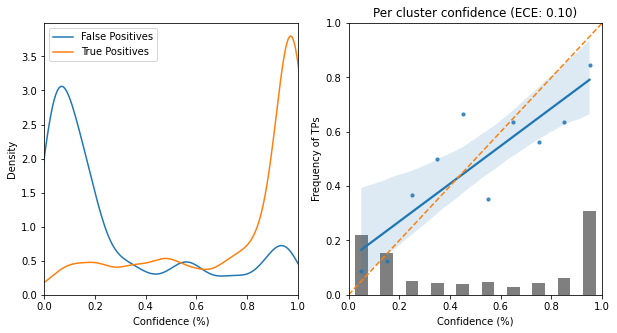

In [ ]:

results_df_saliency = meld_graph.confidence.calculate_per_cluster_confidence(results_dict, 
aggregation_fn='max', mask_by_saliency=True, eva=eva, prediction_suffix=prediction_suffix)
per_cluster_confidence, per_cluster_label = np.array(results_df_saliency['confidence']), np.array(results_df_saliency['TP'])

fig,axes = plt.subplots(1,2, figsize=(10,5))
axes[1] = meld_graph.confidence.confidence_label_distplot(per_cluster_confidence, per_cluster_label,ax=axes[0])
axes[0] = meld_graph.confidence.cluster_calibration_plot(per_cluster_confidence, per_cluster_label,ax=axes[1])

fig.savefig('../figures/calibration.pdf')